In [1]:
import glob
import cv2
from PIL import Image
import numpy as np
import re

### TO DO:
#### Data generation
* replace corner boxes by convex hulls coordinates - suggested scipy.spatial.ConvexHull and save it to dict along with image (see cards dicitionary - variable further down )
* download background textures
* create augmentation pipeline: perspective transformations, change in lightning. Show few examples to verify correctness. (remember to augment bboxes along with images) - suggested imgaug
* figure out a way to automatically position cards on an image (e.g. one cards is nearly all covered by another). Choose randomly background texture but remember it should be more or less uniquely distributed 
* create data, with images consisting with N - number of distinct cards on an image
#### Model
to be continued

In [2]:
def imshow(a):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [3]:
import os

In [4]:
files = glob.glob("data/cards_jpeg/*.jpeg")

In [5]:
cards = {f.split("/")[-1].split(".")[0]: cv2.resize(cv2.imread(f, 1), None, fx=0.3, fy=0.3) for f in files}

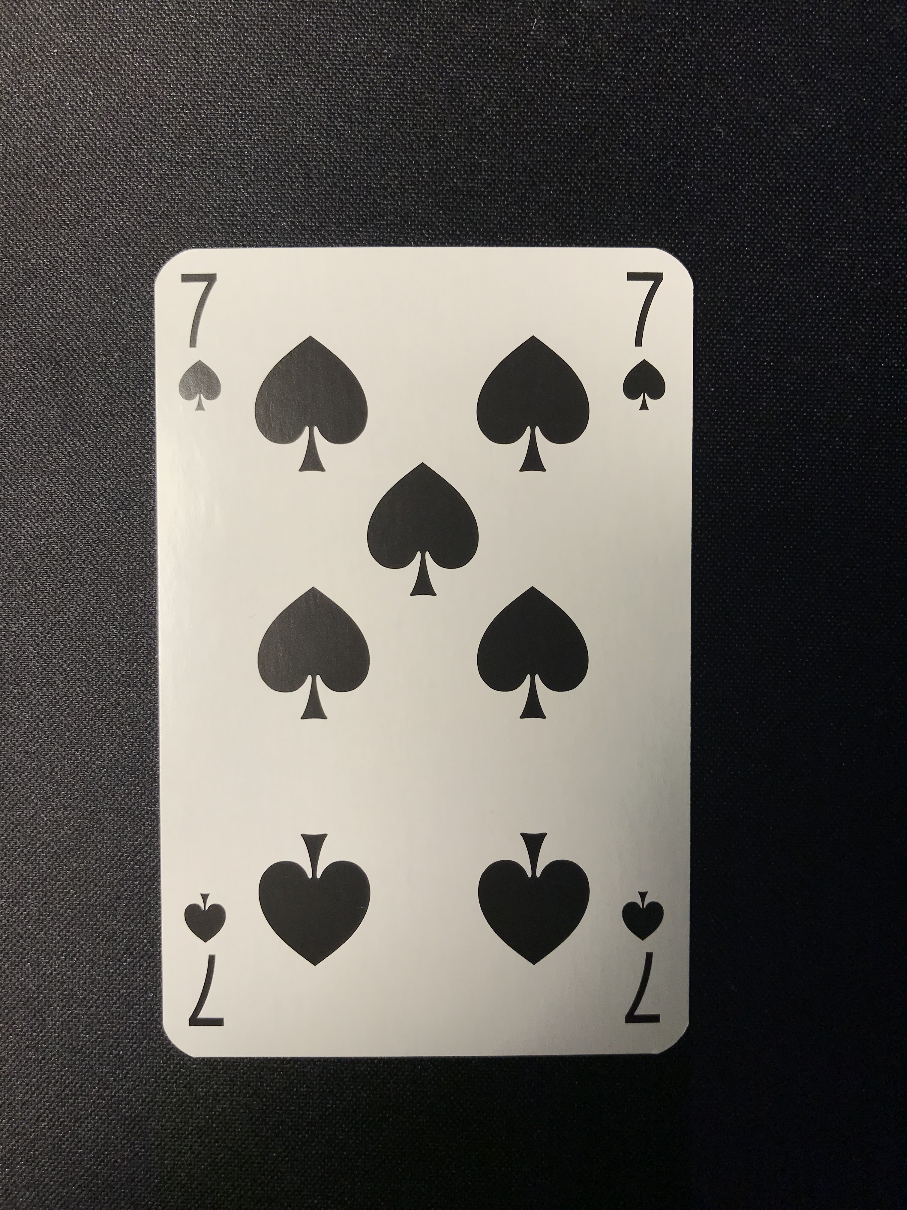

In [6]:
imshow(cards['7s'])

In [7]:
def get_contours(img):
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgray = cv2.GaussianBlur(imgray,(7,7),0)
    laplacian = cv2.Laplacian(imgray, cv2.CV_32F)
    imgray = imgray > 120
    laplacian = laplacian > 5
    #thresh = laplacian.astype('uint8')
    thresh = np.logical_or(imgray, laplacian).astype('uint8')
    thresh *= 255
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        cv2.drawContours(thresh,[cnt],0,255,-1)
    struct = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, struct)
#     imshow(thresh)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    max_area = max(areas)
    out = []
    for i in range(len(contours)):
        if np.abs(areas[i] - max_area) < 10:
            out.append(contours[i])
    return out

In [8]:
def get_bouding_rectangle(cnt):
    rect = cv2.minAreaRect(cnt[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box

In [9]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

In [10]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

In [26]:
def extract_card(im,cnt):
    mask = cv2.drawContours(im.copy(), cnt, -1, (255 , 255 , 255),thickness=cv2.FILLED)
#     imshow(mask)
    mask = cv2.bitwise_not(mask)
#     imshow(mask)
    img2gray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
    mask = cv2.bitwise_not(mask)
    return cv2.bitwise_and(im,im,mask=mask)

cards[36:] is not working

In [27]:
lst = []
for card in cards:
    im = cards[card].copy()
    cnt = get_contours(im)
    im = extract_card(im,cnt)
    box = get_bouding_rectangle(cnt)
    im2 = four_point_transform(im, box)
    cards[card] = im2
#     imshow(im2)

In [94]:
def crop_image(image,size=(157,234)):
    image = cv2.resize(image,size)
    shape = np.array(image.shape[:2]) 
    center = shape/2
    h,w = shape-4
    x = center[1] - w/2
    y = center[0] - h/2
    return image[int(y):int(y+h), int(x):int(x+w)]

In [95]:
min_shape = min([cards[image].shape for image in cards])[:2][::-1]
cards_cropped = {f: {"image":crop_image(im,min_shape)} for f,im in cards.items()}

Corners coordinates are calculated relatively to the image size.

In [96]:
corners = [((2, 4),(26, 48)),((124, 4),(148, 48)),((2, 180),(26, 224)),((124, 180),(148, 224))]
#[LUC,RUC,LLC,RLC]
corners = np.array(corners)/np.array((157, 234)) * min_shape
# print(corners)
KQJ_corners = [((2, 4),(22, 48)),((134, 4),(154, 48)),((2, 180),(22, 224)),((134, 180),(154, 224))]
KQJ_corners = np.array(KQJ_corners)/np.array((157, 234)) * min_shape

In [97]:
for card in cards_cropped:
    im = cards_cropped[card]["image"]
    if re.match('[KQJ]',card) is None:
        cards_cropped[card]['bboxes'] = corners.astype(int) # (start_point,endpoint (x,y))
    else:
        cards_cropped[card]['bboxes'] = KQJ_corners.astype(int)
        

In [98]:
from scipy.spatial import ConvexHull

In [99]:
def get_corner_contours(box):
    box = cv2.cvtColor(box, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(box, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 13)
    imshow(thresh)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]
    max_area = max(areas)
    out = []
    for i in range(len(contours)):
        if np.abs(areas[i] - max_area) < 10:
            out.append(contours[i])
    return out

In [100]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

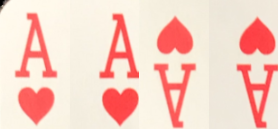

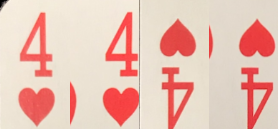

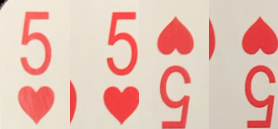

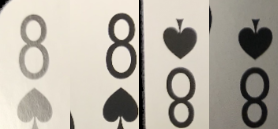

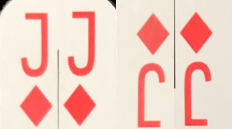

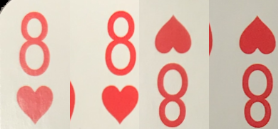

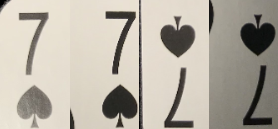

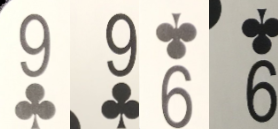

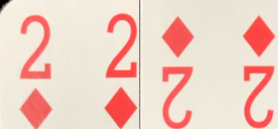

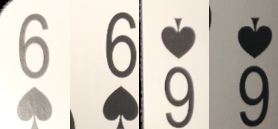

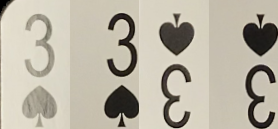

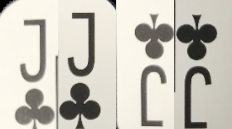

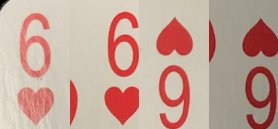

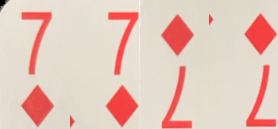

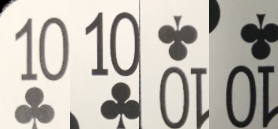

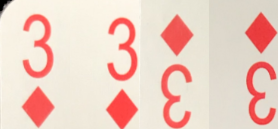

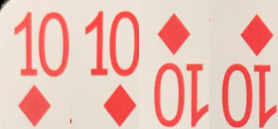

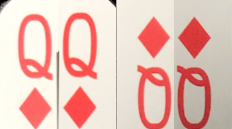

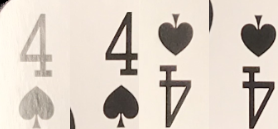

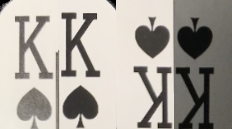

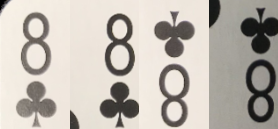

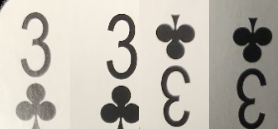

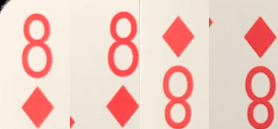

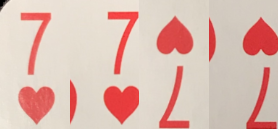

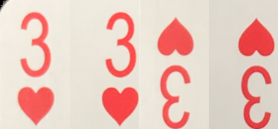

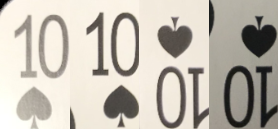

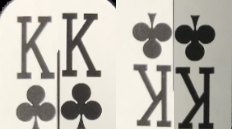

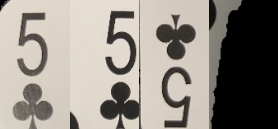

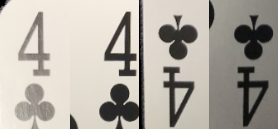

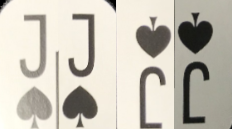

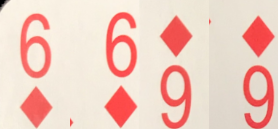

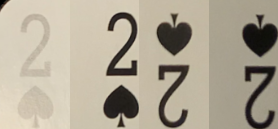

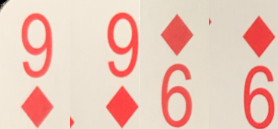

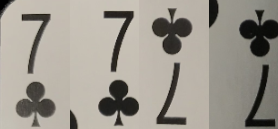

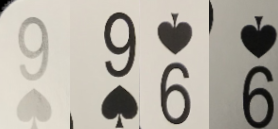

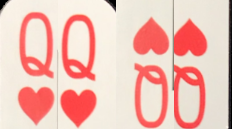

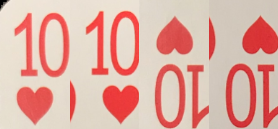

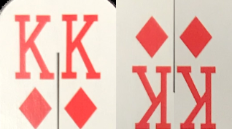

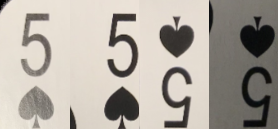

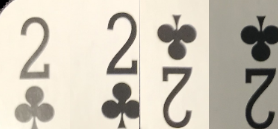

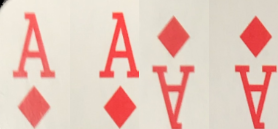

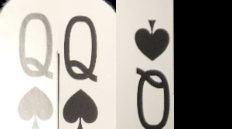

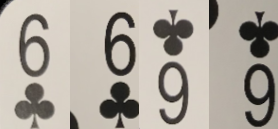

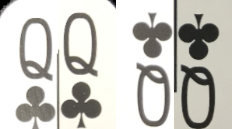

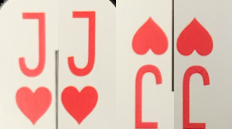

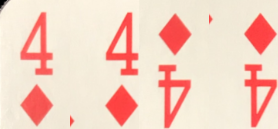

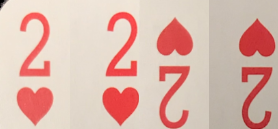

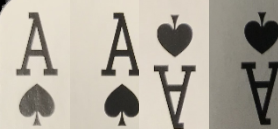

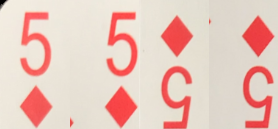

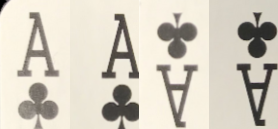

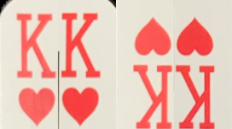

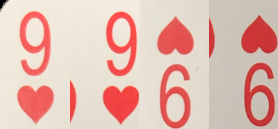

In [103]:
for card in cards_cropped:
    im = cards_cropped[card]["image"]
    bboxes = cards_cropped[card]["bboxes"]
    boxes = []
    for bbox in bboxes:
        x1,x2 = bbox[:,0]
        y1,y2 = bbox[:,1]
        box = im[y1:y2,x1:x2]
        boxes.append(box)
    imshow(np.concatenate(boxes,1))